In [1]:
# Kütüphaneleri import edelim
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from  collections import Counter

#Phyton uyarılarını kapatalım
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Veri aktaralım
data=pd.read_csv("veriseti_20220203_olimpiyatlar.csv")
data.head()

,ID,Name,Gender,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


In [3]:
#Veri yapısını tanıyalım
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271116 entries, 0 to 271115
Data columns (total 15 columns):
ID        271116 non-null int64
Name      271116 non-null object
Gender    271116 non-null object
Age       261642 non-null float64
Height    210945 non-null float64
Weight    208241 non-null float64
Team      271116 non-null object
NOC       271116 non-null object
Games     271116 non-null object
Year      271116 non-null int64
Season    271116 non-null object
City      271116 non-null object
Sport     271116 non-null object
Event     271116 non-null object
Medal     39783 non-null object
dtypes: float64(3), int64(2), object(10)
memory usage: 31.0+ MB


In [4]:
###Verinin Temizlenmesi
#1.Sütun isimlerinin düzenlenmesi
#2.Yararsız verinin çıkarılması ve düzenlenmesi
#3.Eksik veri sorunu

#1.Sütun verilerinin düzenlenmesi
data.columns

Index(['ID', 'Name', 'Gender', 'Age', 'Height', 'Weight', 'Team', 'NOC',
       'Games', 'Year', 'Season', 'City', 'Sport', 'Event', 'Medal'],
      dtype='object')

In [5]:
# 1.a.Sürün isimleri değiştirelim
data.rename(columns={'Name'  : 'isim',
                     'Gender': 'cinsiyet',
                     'Age'   : 'yas',
                     'Height': 'boy',
                     'Weight': 'kilo',
                     'Team'  : 'takim',
                     'NOC'   : 'uok',
                     'Games' : 'oyunlar',
                     'Year'  : 'yil',
                     'Season': 'sezon',
                     'City'  : 'sehir',
                     'Sport' : 'spor',
                     'Event' : 'etkinlik',
                     'Medal' : 'Madalya'},inplace=True)
data.head(2)

,ID,isim,cinsiyet,yas,boy,kilo,takim,uok,oyunlar,yil,sezon,sehir,spor,etkinlik,Madalya
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN


In [6]:
#2.Yararsız verinin çıkarılması ve düzenlenmesi
#drop ile oyunlar sütunun çıkaralım. O bilgi sezonda  ve yilda var.
data=data.drop(['oyunlar'],axis=1) #axis=1 sütun anlamına geliyor.
data.head(2)

,ID,isim,cinsiyet,yas,boy,kilo,takim,uok,yil,sezon,sehir,spor,etkinlik,Madalya
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN


In [7]:
data=data.drop(['ID'],axis=1)
data.head(2)

,isim,cinsiyet,yas,boy,kilo,takim,uok,yil,sezon,sehir,spor,etkinlik,Madalya
0,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN


In [8]:
#3.Eksik veri sorunun çözümü.
#Boy ve ağırlık bilgilerinde eksiklikler var.
# Aynı etkinliklere katılan sporcuların ortalama boy ve ağırığını alıp bu alanları ortalama değerlerle dolduracağız.

In [9]:
unique_etkinlik=pd.unique(data.etkinlik)
print("Eşsiz etkinlik{} ".format(len(unique_etkinlik)))
unique_etkinlik[:5]

Eşsiz etkinlik765 


array(["Basketball Men's Basketball", "Judo Men's Extra-Lightweight",
       "Football Men's Football", "Tug-Of-War Men's Tug-Of-War",
       "Speed Skating Women's 500 metres"], dtype=object)

In [10]:
#Her bir etkinliği iteratif olarak dolaş.
#etkininlik özelinde boy ve kilo ortalamalarını hesapla
#etkinlik özelinde eksik boy ve kilo değerlerini ortalamalar ile doldur.
data_temp = data.copy() # orjinal  veri bozulmasın diye temp aktarıp orad işlem yapacağız.
boy_kilo_list =["boy","kilo"]

for e in unique_etkinlik:#liste içinde dolaş
    #etkinlik filtresi oluştur
    etkinlik_filter = data_temp.etkinlik == e
    #veri etkinliğine göre filitreyelim.
    data_filter=data_temp[etkinlik_filter]
    
    #boy ve kilo için etkinlik özelinde ortalamaları hesapla.
    for s in boy_kilo_list:
        average = np.round(np.mean(data_filter[s]),2)
        if np.isnan(average):# Eğer etkinlik özelinde ortalama yoksa ortalamayı hesapla
            all_data_avg = np.round(np.mean(data[s]),2)
            data_filter[s] = data_filter[s].fillna(all_data_avg) 
        else: #Eğer etkinlik özelinde ortalama varsa
            data_filter[s] =data_filter[s].fillna(average)
    #etkinlik özelinde doldurulmuş veriyi data_temp eşitleyelim.
    data_temp[etkinlik_filter] = data_filter
#kayıp değerleri giderilmiş olan data_temp data ya aktaralım.
data = data_temp.copy()
data.info() # bou ve kilo sutunlarındaki kayıp değer sayısına bakalım.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271116 entries, 0 to 271115
Data columns (total 13 columns):
isim        271116 non-null object
cinsiyet    271116 non-null object
yas         261642 non-null float64
boy         271116 non-null float64
kilo        271116 non-null float64
takim       271116 non-null object
uok         271116 non-null object
yil         271116 non-null int64
sezon       271116 non-null object
sehir       271116 non-null object
spor        271116 non-null object
etkinlik    271116 non-null object
Madalya     39783 non-null object
dtypes: float64(3), int64(1), object(9)
memory usage: 26.9+ MB


In [11]:
#Yaş değişkeninde tanımlı olamayan değerleri bulalım ve ortalamayı ekleyelim.
yas_average = np.round(np.mean(data.yas),2)
print("Yaş ortalaması {} ".format(yas_average))
data["yas"] = data["yas"].fillna(yas_average)
data.info()

Yaş ortalaması 25.56 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271116 entries, 0 to 271115
Data columns (total 13 columns):
isim        271116 non-null object
cinsiyet    271116 non-null object
yas         271116 non-null float64
boy         271116 non-null float64
kilo        271116 non-null float64
takim       271116 non-null object
uok         271116 non-null object
yil         271116 non-null int64
sezon       271116 non-null object
sehir       271116 non-null object
spor        271116 non-null object
etkinlik    271116 non-null object
Madalya     39783 non-null object
dtypes: float64(3), int64(1), object(9)
memory usage: 26.9+ MB


In [12]:
#Madalya alamayan sprocuları veri setinden çıkaralım.
madalya_variable = data["Madalya"]
pd.isnull(madalya_variable).sum()

231333

In [13]:
# ~ isareti ! isareti gibi not anlami katar. Burada isnull olayanlari getir deniyor
madalya_variable_filter = ~pd.isnull(madalya_variable) 

In [14]:
data = data[madalya_variable_filter]
data.head(5)

,isim,cinsiyet,yas,boy,kilo,takim,uok,yil,sezon,sehir,spor,etkinlik,Madalya
3,Edgar Lindenau Aabye,M,34.0,182.48,95.62,Denmark/Sweden,DEN,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
37,Arvo Ossian Aaltonen,M,30.0,182.01,76.69,Finland,FIN,1920,Summer,Antwerpen,Swimming,Swimming Men's 200 metres Breaststroke,Bronze
38,Arvo Ossian Aaltonen,M,30.0,177.00,75.00,Finland,FIN,1920,Summer,Antwerpen,Swimming,Swimming Men's 400 metres Breaststroke,Bronze
40,Juhamatti Tapio Aaltonen,M,28.0,184.00,85.00,Finland,FIN,2014,Winter,Sochi,Ice Hockey,Ice Hockey Men's Ice Hockey,Bronze
41,Paavo Johannes Aaltonen,M,28.0,175.00,64.00,Finland,FIN,1948,Summer,London,Gymnastics,Gymnastics Men's Individual All-Around,Bronze


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39783 entries, 3 to 271103
Data columns (total 13 columns):
isim        39783 non-null object
cinsiyet    39783 non-null object
yas         39783 non-null float64
boy         39783 non-null float64
kilo        39783 non-null float64
takim       39783 non-null object
uok         39783 non-null object
yil         39783 non-null int64
sezon       39783 non-null object
sehir       39783 non-null object
spor        39783 non-null object
etkinlik    39783 non-null object
Madalya     39783 non-null object
dtypes: float64(3), int64(1), object(9)
memory usage: 4.2+ MB


In [16]:
#sonradan kullanmak için harddiske kayıt edelim.
data.to_csv("olimpiyatlar_temizlenmis.csv",index=False)

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39783 entries, 3 to 271103
Data columns (total 13 columns):
isim        39783 non-null object
cinsiyet    39783 non-null object
yas         39783 non-null float64
boy         39783 non-null float64
kilo        39783 non-null float64
takim       39783 non-null object
uok         39783 non-null object
yil         39783 non-null int64
sezon       39783 non-null object
sehir       39783 non-null object
spor        39783 non-null object
etkinlik    39783 non-null object
Madalya     39783 non-null object
dtypes: float64(3), int64(1), object(9)
memory usage: 4.2+ MB


#Sayısal Değişkenler
yas
boy
kilo
yil
#Kategorik değişkenler
isim
cinsiyet    
takim    
uok   
sezon      
sehir     
spor        
etkinlik    
Madalya     

In [19]:
# sayısal değerleri histogram , sutun ve bıyık grafi ile temsil edeceğiz. bkz. https://www.data-to-viz.com/ 
# Histogram çizimi için function yazalım
def plotHistogram (variable):
    """
      Girdi :Değişgen / Sütun ismi
      Çıktı :İlgili değişkenin histogramı
    """
    plt.figure()
    plt.hist(data[variable], bins = 85, color = "orange")
    plt.xlabel(variable)
    plt.ylabel("Frekans")
    plt.title("Veri Sıklığı {} ".format(variable))
    plt.show

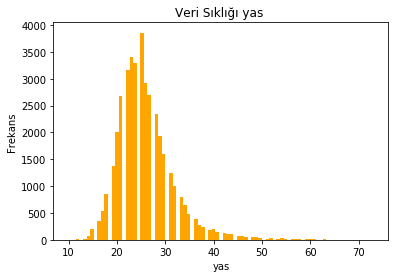

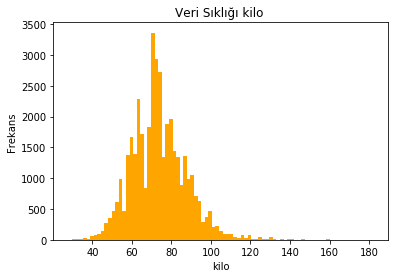

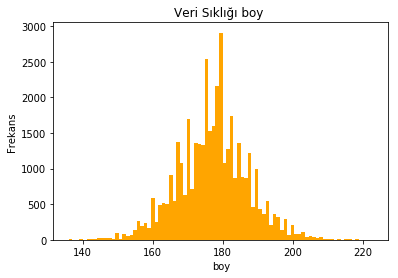

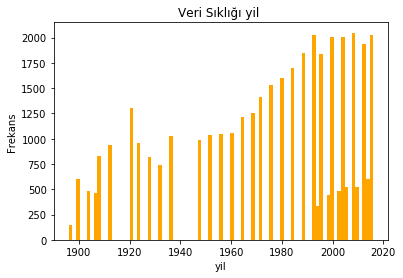

In [20]:
# Tüm sayısal değerler için histogramları çizdirelim.
numeric_variable=["yas","kilo","boy","yil"]
for numvar in numeric_variable:
    plotHistogram(numvar)

In [21]:
data.describe()

,yas,boy,kilo,yil
count,39783.000000,39783.000000,39783.000000,39783.000000
mean,25.918456,177.336690,73.738320,1973.943845
std,5.859569,10.170124,13.979041,33.822857
min,10.000000,136.000000,28.000000,1896.000000
25%,22.000000,170.000000,64.000000,1952.000000
50%,25.000000,177.480000,73.000000,1984.000000
75%,29.000000,184.000000,82.000000,2002.000000
max,73.000000,223.000000,182.000000,2016.000000


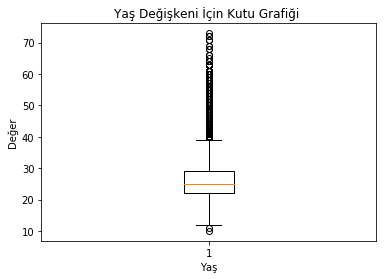

In [22]:
#Yaş değişkeni için kutu grafiği
plt.boxplot(data.yas)
plt.title("Yaş Değişkeni İçin Kutu Grafiği ")
plt.xlabel("Yaş")
plt.ylabel("Değer")
plt.show()

#Kategorik değişkenler isim cinsiyet
takim
uok
sezon
sehir
spor
etkinlik
Madalya

In [23]:
# Kategorik değişgenler için sütun grafi kullanabiliz.
#Çubuk grafiği için function(method) oluşturalım
def plotBar(variable,n=5):
    """
        Girdi : variable = değişken / sütun ismi
                n = Gösterilecek eşsiz değerler 
        Çıktı : Bar(Çubuk) grafiği 
    """
    _data = data[variable]
    data_count = _data.value_counts()
    data_count = data_count[:n]
    plt.figure()
    plt.bar(data_count.index,data_count, color = "orange")
    plt.xticks(data_count.index,data_count.index.values)
    plt.xticks(rotation = 60)
    plt.ylabel("Frekans")
    plt.title("Veri Sıklığı - {} ".format(variable))
    plt.show()
    print("[] \n {} ".format(variable,data_count))

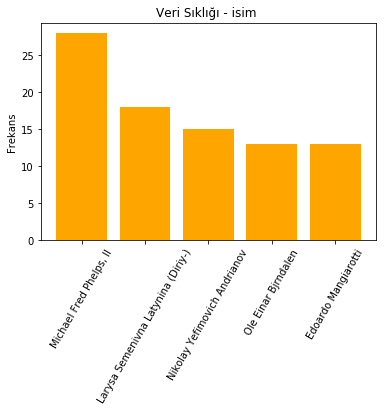

[] 
 isim 


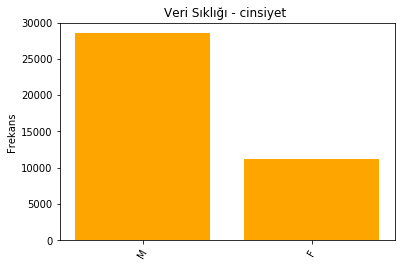

[] 
 cinsiyet 


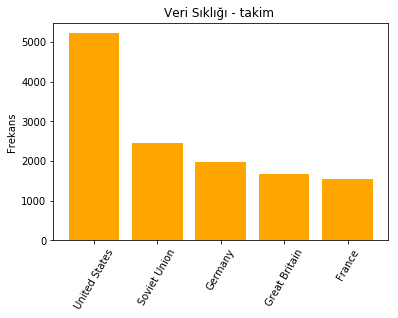

[] 
 takim 


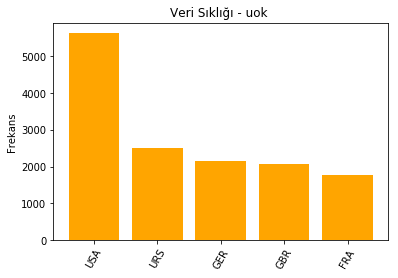

[] 
 uok 


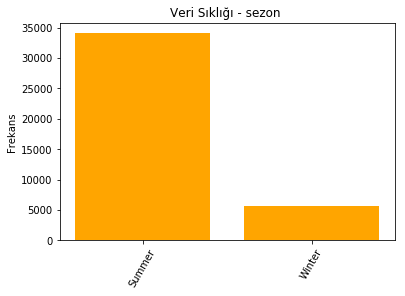

[] 
 sezon 


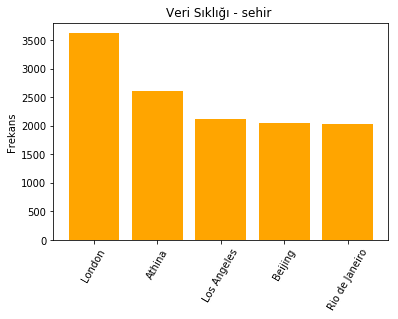

[] 
 sehir 


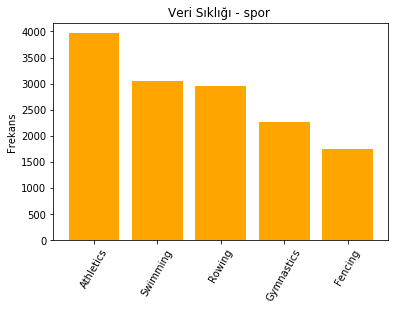

[] 
 spor 


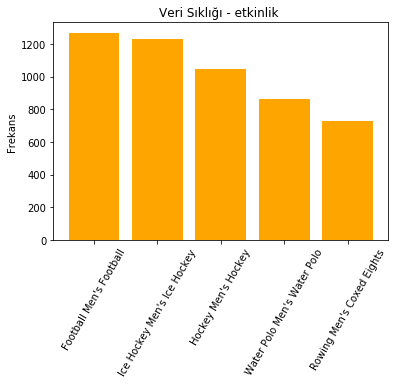

[] 
 etkinlik 


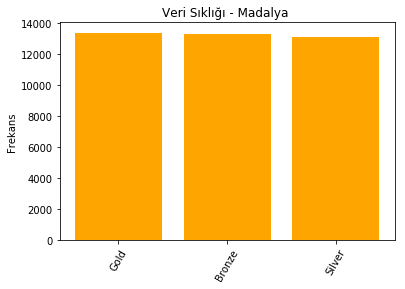

[] 
 Madalya 


In [88]:
categoric_variables=["isim", "cinsiyet", "takim", "uok", "sezon", "sehir", "spor", "etkinlik", "Madalya"]
for catvar in categoric_variables:
    plotBar(catvar)

In [24]:
#Cinsiyete göre boy ve kilo karşılaştırması
erkek= data[data.cinsiyet=="M" ]
erkek.head()

,isim,cinsiyet,yas,boy,kilo,takim,uok,yil,sezon,sehir,spor,etkinlik,Madalya
3,Edgar Lindenau Aabye,M,34.0,182.48,95.62,Denmark/Sweden,DEN,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
37,Arvo Ossian Aaltonen,M,30.0,182.01,76.69,Finland,FIN,1920,Summer,Antwerpen,Swimming,Swimming Men's 200 metres Breaststroke,Bronze
38,Arvo Ossian Aaltonen,M,30.0,177.00,75.00,Finland,FIN,1920,Summer,Antwerpen,Swimming,Swimming Men's 400 metres Breaststroke,Bronze
40,Juhamatti Tapio Aaltonen,M,28.0,184.00,85.00,Finland,FIN,2014,Winter,Sochi,Ice Hockey,Ice Hockey Men's Ice Hockey,Bronze
41,Paavo Johannes Aaltonen,M,28.0,175.00,64.00,Finland,FIN,1948,Summer,London,Gymnastics,Gymnastics Men's Individual All-Around,Bronze


In [25]:
kadin = data[data.cinsiyet=="F"]
kadin.head(3)

,isim,cinsiyet,yas,boy,kilo,takim,uok,yil,sezon,sehir,spor,etkinlik,Madalya
79,Ragnhild Margrethe Aamodt,F,27.0,163.00,68.88,Norway,NOR,2008,Summer,Beijing,Handball,Handball Women's Handball,Gold
91,Willemien Aardenburg,F,22.0,166.13,60.53,Netherlands,NED,1988,Summer,Seoul,Hockey,Hockey Women's Hockey,Bronze
105,Ann Kristin Aarnes,F,23.0,182.00,64.00,Norway,NOR,1996,Summer,Atlanta,Football,Football Women's Football,Bronze


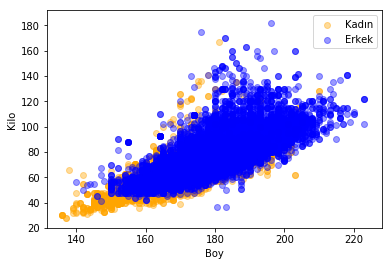

In [26]:
plt.figure()
plt.scatter(kadin.boy,kadin.kilo,alpha=0.4,label="Kadın",color="orange")
plt.scatter(erkek.boy,erkek.kilo,alpha=0.4,label="Erkek",color="blue")
plt.xlabel("Boy")
plt.ylabel("Kilo")
plt.legend()
plt.show()

In [27]:
#Sayısal sütunlar arasında ilişki incelemesi
data.loc[:,["yas","boy","kilo"]].corr() #kolerasyon tablosu

,yas,boy,kilo
yas,1.000000,0.061890,0.136349
boy,0.061890,1.000000,0.794368
kilo,0.136349,0.794368,1.000000


## Madalya ve yaş arasındaki ilişki 

In [28]:
#Sporcuları ladıkları madalya ya göre gruplandıralım.
"""
altin=data[data.Madalya=="Gold"] #kategorik değişkenler
altin.head()
bronz= data[data.Madalya=="Bronze"]
bronz.head()
gumus=data[data.Madalya=="Silver"]
gumus.head()
"""
#Kategorik değişken olan Madalyadan sayısal değer oluşturalım.
data_temp=data.copy() #Yedeğini alım
data_temp= pd.get_dummies(data_temp,columns=['Madalya'])
data_temp.head(3)

,isim,cinsiyet,yas,boy,kilo,takim,uok,yil,sezon,sehir,spor,etkinlik,Madalya_Bronze,Madalya_Gold,Madalya_Silver
3,Edgar Lindenau Aabye,M,34.0,182.48,95.62,Denmark/Sweden,DEN,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,0,1,0
37,Arvo Ossian Aaltonen,M,30.0,182.01,76.69,Finland,FIN,1920,Summer,Antwerpen,Swimming,Swimming Men's 200 metres Breaststroke,1,0,0
38,Arvo Ossian Aaltonen,M,30.0,177.00,75.00,Finland,FIN,1920,Summer,Antwerpen,Swimming,Swimming Men's 400 metres Breaststroke,1,0,0


In [29]:
data_temp.loc[:,["yas","Madalya_Bronze","Madalya_Gold","Madalya_Silver"]].corr()

,yas,Madalya_Bronze,Madalya_Gold,Madalya_Silver
yas,1.000000,-0.005584,-0.002576,0.008192
Madalya_Bronze,-0.005584,1.000000,-0.504110,-0.496859
Madalya_Gold,-0.002576,-0.504110,1.000000,-0.499022
Madalya_Silver,0.008192,-0.496859,-0.499022,1.000000


## Takımların altın , gümüş ve bronz madalya sayıları


In [30]:
#data_temp.loc kullanımı
data_temp.loc[:,["takim","Madalya_Bronze","Madalya_Gold","Madalya_Silver"]].groupby(["takim"],as_index=False).sum().sort_values(by="Madalya_Gold",ascending=False)[:10]

,takim,Madalya_Bronze,Madalya_Gold,Madalya_Silver
462,United States,1233.0,2474.0,1512.0
403,Soviet Union,677.0,1058.0,716.0
165,Germany,678.0,679.0,627.0
215,Italy,484.0,535.0,508.0
171,Great Britain,572.0,519.0,582.0
149,France,577.0,455.0,518.0
420,Sweden,507.0,451.0,476.0
198,Hungary,365.0,432.0,330.0
67,Canada,408.0,422.0,413.0
117,East Germany,263.0,369.0,309.0


In [31]:
#data_temp kullanımı
data_temp[["takim","Madalya_Bronze","Madalya_Gold","Madalya_Silver"]].groupby(["takim"],as_index=False).sum().sort_values(by="Madalya_Gold",ascending=False)[:10]

,takim,Madalya_Bronze,Madalya_Gold,Madalya_Silver
462,United States,1233.0,2474.0,1512.0
403,Soviet Union,677.0,1058.0,716.0
165,Germany,678.0,679.0,627.0
215,Italy,484.0,535.0,508.0
171,Great Britain,572.0,519.0,582.0
149,France,577.0,455.0,518.0
420,Sweden,507.0,451.0,476.0
198,Hungary,365.0,432.0,330.0
67,Canada,408.0,422.0,413.0
117,East Germany,263.0,369.0,309.0


## Kazanılan madalyaların hangi şehirlerde kazanıldığı

In [32]:
data_temp[["sehir","Madalya_Bronze","Madalya_Gold","Madalya_Silver"]].groupby(["sehir"],as_index=False).sum().sort_values(by="Madalya_Gold",ascending=False)[:10]

,sehir,Madalya_Bronze,Madalya_Gold,Madalya_Silver
17,London,1214.0,1215.0,1195.0
3,Athina,860.0,883.0,859.0
18,Los Angeles,706.0,726.0,691.0
6,Beijing,710.0,671.0,667.0
27,Rio de Janeiro,703.0,665.0,655.0
38,Sydney,680.0,663.0,661.0
4,Atlanta,629.0,608.0,605.0
5,Barcelona,604.0,559.0,549.0
33,Seoul,549.0,520.0,513.0
2,Antwerpen,367.0,493.0,448.0


## Cinsiyete göre madalya sayıları

In [33]:
data_temp[["cinsiyet","Madalya_Bronze","Madalya_Gold","Madalya_Silver"]].groupby(["cinsiyet"],as_index=False).sum().sort_values(by="Madalya_Gold",ascending=False)[:10]

,cinsiyet,Madalya_Bronze,Madalya_Gold,Madalya_Silver
1,M,9524.0,9625.0,9381.0
0,F,3771.0,3747.0,3735.0


#  Çok Değikenli Veri Analizi
## Pivot Table

In [34]:
data_pivot = data.pivot_table(index="Madalya",columns="cinsiyet",
                             values=["boy","kilo","yas"],
                             aggfunc={"boy":np.mean,"kilo":np.mean,"yas":[min,max,np.std]})
data_pivot.head()

boy                   kilo              yas              \
                mean                   mean              max         min   
cinsiyet           F           M          F          M     F     M     F   
Madalya                                                                    
Bronze    170.003227  180.045806  62.757125  77.841504  69.0  72.0  12.0   
Gold      170.448727  180.318906  63.199349  78.186505  63.0  64.0  13.0   
Silver    170.233783  180.053626  62.866892  77.960887  55.0  73.0  11.0   

                                    
                     std            
cinsiyet     M         F         M  
Madalya                             
Bronze    10.0  5.329229  5.870340  
Gold      13.0  5.219615  5.987807  
Silver    13.0  5.253111  6.098221

# Anomali Tespiti.  
Bıyık grafiğinde net olarak gözüken aykırı değerlerin anomalisini tespit etme.

In [41]:
def anomalyDetection(dataFrame,feature):
    outlier_indices = []
    for column in feature:
        # 1. Quartile
        Q1 = np.percentile(dataFrame[column],25)
        # 3. Quartile
        Q3 = np.percentile(dataFrame[column],75)
        # IQR = Inter Quartile Range
        IQR = Q3 - Q1
        # attachment step for outlier.
        outlier_step= 1.5 * IQR
        #found index 
        outlier_list_col = dataFrame[(dataFrame[column]< Q1 - outlier_step) | (dataFrame[column]> Q3 + outlier_step)].index
        #index save
        outlier_indices.extend(outlier_list_col)
        
    # unique outlier values will found 
    outlier_indices = Counter(outlier_indices)
    multiplie_outliers = list(i for i, v in outlier_indices.items() if v > 1 )
    return multiplie_outliers
        

In [42]:
data_anomaly = data.loc[anomalyDetection(data,["yas","kilo","boy"])]
data_anomaly.spor.value_counts()

Basketball        64
Gymnastics        34
Handball           6
Athletics          5
Diving             3
Sailing            3
Shooting           1
Wrestling          1
Figure Skating     1
Name: spor, dtype: int64